In [1]:
import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
%pylab
%matplotlib inline
import matplotlib as mpl
plt.ioff()
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
from __future__ import print_function
import gc
from tqdm import tqdm
from __future__ import division

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sb
import torch as T
import torch
import os
import skvideo
from tqdm import tqdm
import skvideo.io
from scipy.spatial import distance
from scipy.cluster import hierarchy
%matplotlib inline

In [3]:
2 / np.arange(1,4)

array([2.        , 1.        , 0.66666667])

In [4]:
class FishSeqData(Dataset):    
    def __init__(self, u, p, x,n_future_steps=1):
        self.x = nn.Parameter(x,requires_grad=False)
        self.p = nn.Parameter(p,requires_grad=False)
        self.u = nn.Parameter(u,requires_grad=False)
        self.nfeatures = x.shape[1]
        self.n_future_steps = n_future_steps
        
    def __len__(self):
        return len(self.x)-self.n_future_steps

    def __getitem__(self, idx):
        indices = slice(idx,idx+self.n_future_steps)
        x_true_indices = slice(idx+1,idx+self.n_future_steps+1)
        return (self.u[indices], self.p[indices],
                self.x[indices], self.x[x_true_indices])

class DynamicsCluster(nn.Module,):
    def __init__(self, nfeatures, neuron_cluster_map, n_future_steps,dtype=T.float32, scale=1,std=0.1):
        """DCM model with dynamics between nclusters = max(neuron_cluster_map) features and dense mapping from
        nfeatures -> nclusters"""
        super(DynamicsSeq, self).__init__()
        if dtype==T.float32:
            tensor = T.cuda.FloatTensor
        elif dtype==T.float16:
            tensor = T.cuda.HalfTensor
        nclusters = max(neuron_cluster_map)
        self.nclusters = nclusters
        self.cluster = []
        for i in range(nclusters):
            idx = np.argwhere(neuron_cluster_map==i)
            self.cluster.append(idx)
        self.Dense = nn.Parameter(tensor(nfeatures).normal_(std), requires_grad=True)
        self.A = nn.Parameter(tensor(nclusters,nclusters).normal_(std),requires_grad=True)
        self.B = nn.Parameter(tensor(nclusters,nclusters).normal_(std),requires_grad=True)
        self.C = nn.Parameter(tensor(nclusters).normal_(std),requires_grad=True)
        self.n_future_steps = n_future_steps
        self.tensor = tensor
        self.scale = scale
        self.dtype = dtype

    def forward(self, u, p, x_true, n_future_steps=None):
        if n_future_steps==None:
            n_future_steps = self.n_future_steps
        x = self.tensor(x_true.shape[0], 1+x_true.shape[1], *x_true.shape[2:]).zero_()
        x[:,0] = x_true[:,0]
        for t in range(n_future_steps):
            # batch x time x feature
            X = T.cuda.FloatTensor(x_true.shape[0],self.nclusters, 1).zero_()
            for i in range(self.nclusters):
                idx = self.cluster[i]
                # broadcast inner product
                X[:,i] = T.matmul(self.Dense[idx], x_true[:,t,idx,None])
            dxdt = (T.matmul((self.A + p[:,t,None,None]*self.B), X).squeeze()) + u[ :,t,None]*self.C
            assert dxdt.shape == [x_true.shape[0],self.nclusters, 1]
            for i in range(self.nclusters):
                idx = self.cluster[i]
                x[:,t+1,idx] = dxdt[:,i]/self.Dense[idx] + x[:,t,idx]
        return x[:,1:]

def train(model,data,nepochs=10, lambdaA=(1e-8, 1e-6), lambdaB=(1e-6, 1e-6),
          lambdaC=(1e-5, 1e-5), lambdaD=(1e-5, 1e-5), lr=0.1, verbose=True):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    if verbose:
        A_loss = F.mse_loss(model.A.data,A_true)
        print("A_loss: {}".format(A_loss))
    cum_mse_loss = 0
    with T.no_grad():
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            cum_mse_loss += F.mse_loss(X_pred.float(),X_true.float())
        nfeatures = X_true.shape[2]
        print("mse_loss: {:3E}".format(cum_mse_loss/nfeatures))
#     optimizer = T.optim.SGD(model.parameters(),lr=lr)
    optimizer = T.optim.Adam(model.parameters(),lr=lr,amsgrad=True)
    for e in range(nepochs):
        if verbose:
            print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_mse_loss = 0
        for batch_data in tqdm(dataloader):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            l_A = lambdaA[0] * model.A.norm(1) + lambdaA[1] * model.A.norm(2)
            l_B = lambdaB[0] * model.B.norm(1) + lambdaB[1] * model.B.norm(2)
            l_C = lambdaC[0] * model.C.norm(1) + lambdaC[1] * model.C.norm(2)
            l_D1 = lambdaD[0] * model.Dense1.norm(1) + lambdaD[1] * model.Dense1.norm(2)
#             l_D2 = lambdaD[0] * model.Dense2.norm(1) + lambdaD[1] * model.Dense2.norm(2)
            mse_loss = F.mse_loss(X_pred,X_true)
            loss = mse_loss + l_A + l_B + l_C + l_D1 #+ l_D2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_mse_loss += float(mse_loss)
            del X_pred, U,P,X, X_true, mse_loss, l_A, l_B, loss
            gc.collect()
            torch.cuda.empty_cache()

        if verbose:
            A_loss = F.mse_loss(model.A.data,A_true)
            B_loss = F.mse_loss(model.B.data,B_true)
            C_loss = F.mse_loss(model.C.data,C_true)
            print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))
        print("cum_loss: {:3E}, mse_loss: {:3E}".format(cum_loss,cum_mse_loss/nfeatures))
    
    if verbose:
        print("pred_loss: {}, A_loss: {}, B_loss: {}, C_loss: {}".format(cum_loss,A_loss,B_loss,C_loss))
        
def predict(model,data, batch_size=32):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False)
    with T.no_grad():
        pred = T.cuda.FloatTensor(len(data),*data[0][2].shape).zero_()
        for i, batch_data in enumerate(tqdm(dataloader)):
            U,P,X, X_true = batch_data
            X_pred = model(U,P,X)
            pred[i*batch_size:(i+1)*batch_size] = X_pred
    return pred


def model_v_truth(model,u,p,x_true,A_true=None, B_true=None):
    if model.dtype==T.float16:
        A = model.A.data.float()*model.scale
        B = model.B.data.float()*model.scale
    else:
        A = model.A.data
        B = model.B.data
    x_pred = predict(model,data).squeeze()
    fig = plt.figure(figsize=(10,10))
    spec = gridspec.GridSpec(ncols=2, nrows=3)
    anno_opts = dict(xy=(0.5, 0.5), xycoords='axes fraction',
                     va='center', ha='center')

    ax1 = fig.add_subplot(spec[0,0:])
    ax2 = fig.add_subplot(spec[1, 0])
    ax3 = fig.add_subplot(spec[1, 1])
    ax4 = fig.add_subplot(spec[2, 0])
    ax5 = fig.add_subplot(spec[2, 1])
    
    dx_pred = x_pred - x_true[:-1]
#     ax1.plot(dx_pred.mean(1).cpu().numpy(),color='red', label="Model")
    ax1.plot(x_pred[:,2].cpu().numpy(),color='red', label="Model")
    ax1.set_ylabel("dx/dt")
    ax1.set_xlabel("Time")
    ax1.set_title("Witheld test data")
    dx_true = x_true[1:] - x_true[:-1]
    ax1.plot(dx_true.mean(1).cpu().numpy(),color="gray",linewidth=5, alpha=0.7,label="Truth")
    ax1.legend()
    
    if not A_true==None:
        mymax = max(A_true.max(), A.max())
        mymin = min(A_true.min(), A.min())
        im = ax2.imshow(A_true.cpu(),vmin=mymin,vmax=mymax)
        ax2.set_title("A true")
        ax3.imshow(A.cpu(),vmin=mymin,vmax=mymax)
        ax3.set_title("A model")
    else:
        ax3.imshow(A.cpu())
#     cax,kw = mpl.colorbar.make_axes([ax2, ax3])
#     fig.colorbar(im, cax=cax, **kw)
    
    if not B_true==None:
        mymax = max(B_true.max(), B.max())
        mymin = min(B_true.min(), B.min())
        im2 = ax4.imshow(B_true.cpu(),vmin=mymin,vmax=mymax)
        ax4.set_title("B true")
        ax5.imshow(B.cpu(),vmin=mymin,vmax=mymax)
        ax5.set_title("B model")
    else:
        ax5.imshow(B.cpu())
#     cax,kw = mpl.colorbar.make_axes([ax4, ax5])
#     fig.colorbar(im2, cax=cax, **kw)
    
    fig.tight_layout()
    return fig

# Fish code

In [5]:
import os, sys, datetime
LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
sys.path.insert(0,LF_CODE_PATH)
sys.path.insert(0,FT_CODE_PATH)
sys.path.insert(0,FD_CODE_PATH)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pims
import numpy as np
import pandas as pd
import scipy
import skimage.io
import visualization_utils as vizutil
import seaborn as sns
from skimage.filters import gaussian_filter

import passivity_2p_imaging_utils as p2putils
reload(p2putils)
tmp_dir = '/tmp/'
all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
f = all_data['e'][2]

In [7]:
print('The first shock started at t=', f.get_shock_start_time(), 's')#shock start times
print('The first slice of the frame began being imaged at t=', f.frame_st[0,0], 's') #time at which each slice was imaged [#samples X #slices]
print('The first tail movement started at=', f.tail_movement_start_times[0], 's') #tail movement times - movements separted into forward swims, turns and escapes.
print('Num z-planes imaged:', f.num_zplanes)
print('Volume-Rate:', 1/np.diff(f.frame_st[:,0]).mean()) #frame_st is #frames x #slices, we examine interval between imaging first slice

The first shock started at t= 448.9964299699543 s
The first slice of the frame began being imaged at t= 12.446 s
The first tail movement started at= 102.5907 s
Num z-planes imaged: 11
Volume-Rate: 1.0131832172386757


Demo code for examining movie of tail (slowed by factor of 5)

In [8]:
movement_ndx = 10
clip = f.get_tail_movie_clip(f.tail_movement_start_times[movement_ndx]-.1, 
                             f.tail_movement_end_times[movement_ndx]+.1, 
                             playback_speed_factor=.2)
clip.ipython_display(width=150)

100%|██████████| 291/291 [00:00<00:00, 4632.80it/s]


Text(0.5,0,'Time Relative to First Shock (s)')

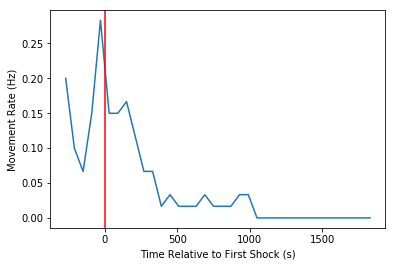

In [9]:
rate_window_starts = np.arange(-300,31*60,60) + f.get_shock_start_time() #1 minutes windows around start of shock
rate_window_centers = rate_window_starts + 30
rate_windows_adj = rate_window_starts - f.td_time[0] #corrected for the fact that get_movement_rate wants time relative to start of tail imaging.
plt.plot(rate_window_centers - f.get_shock_start_time(), [f.get_movement_rate([x,x+60], bExcShockResp=False) for x in rate_windows_adj])
plt.axvline(0,c='r')
plt.ylabel('Movement Rate (Hz)')
plt.xlabel('Time Relative to First Shock (s)')

In [10]:
df = f.get_roi_table() #this can be slow to run the first time as data is loaded from files
df.head()

,fishid,z,zndx,roi_img_label,coords,centroid_x,centroid_y,area,solidity,eccentricity,...,in_l_tel,in_r_ctel,in_l_LHb,in_l_MHb,in_r_vthal,in_r_MHb,in_l_dthal,region,hemisphere,region_bilat
0,f01555,0,0,1,"[[1, 27], [1, 28], [2, 26], [2, 27], [2, 28], ...",2.200000,27.200000,10,0.909091,0.828852,...,False,False,False,False,False,False,False,other,w,other
1,f01555,0,1,2,"[[1, 56], [1, 57], [1, 58], [1, 59], [1, 60], ...",1.923077,57.692308,13,1.000000,0.774346,...,False,False,False,False,False,False,False,other,w,other
2,f01555,0,2,3,"[[1, 61], [1, 62], [1, 64], [1, 65], [2, 62], ...",2.076923,63.461538,13,0.764706,0.872165,...,False,False,False,False,False,False,False,other,w,other
3,f01555,0,3,4,"[[1, 83], [1, 84], [1, 85], [1, 86], [2, 82], ...",2.076923,84.384615,13,0.928571,0.656671,...,False,False,False,False,False,False,False,other,w,other
4,f01555,0,4,5,"[[1, 87], [1, 88], [1, 89], [1, 90], [1, 91], ...",3.517857,90.446429,56,0.767123,0.888139,...,False,False,False,False,False,False,False,l_wholebrain,l,wholebrain


In [11]:
M = f.get_signals_raw(z=None)
# Mf = hbutils.df_over_f(M)

There are also various methods for grabbing the raw imaging data:  
get_tif_as_vol  
get_tif_rasl

We can use this to visualize a few ROIs in particular plane/slice and brain region:

multi


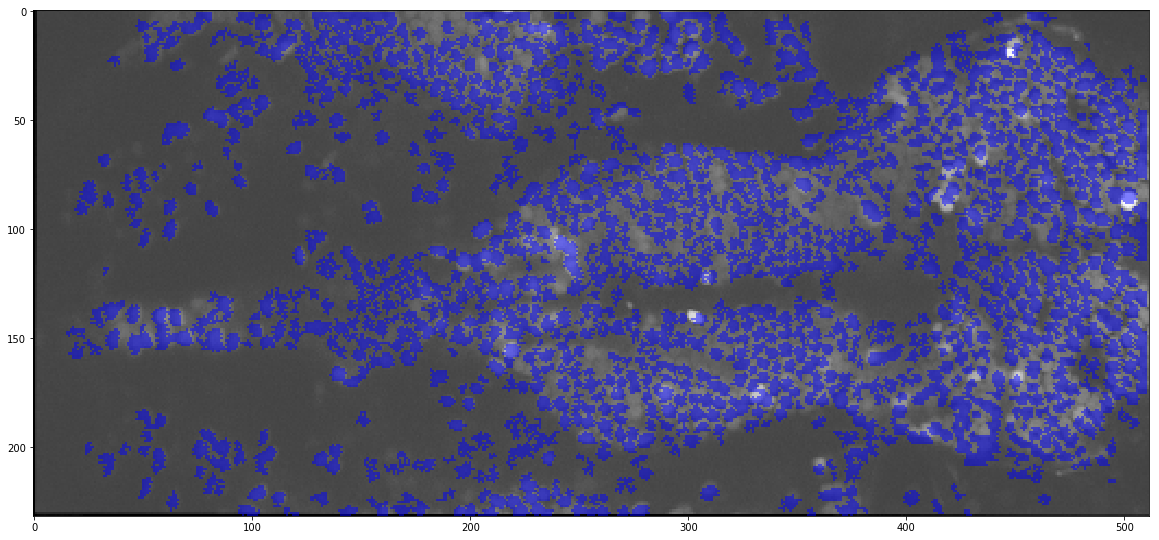

In [12]:
z=10

#Create a background image by averaging 200 frames and adjusting the gamma.
back_img = np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4)

#Select rois in raphe in this slices, and get their coordinates.
coords = df[(df.z==z)].coords

#Overlay the ROIs on the background image and display:
img = vizutil.overlay_coords(back_img, coords, [0,0,1], alpha=.5)
plt.figure(figsize=[20,20])
plt.imshow(img,interpolation='nearest')

In [13]:
def get_poly_area(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def get_roi_area(poly_coords):
    """Get area of an rois.
    Args:
    poly_coords: is numpy matrix #vertices x 2.  NAN rows mean coords separates multiple polygons.
    """
    #split poly_coords into list of polys based on nan rows
    poly_list = np.split(poly_coords, np.where(np.isnan(poly_coords).any(axis=1))[0])
    
    #clean up by removing nan rows
    poly_list = [poly[~np.isnan(poly).any(axis=1)] for poly in poly_list] #remove nan
    
    areas = [get_poly_area(poly[:,0],poly[:,1]) for poly in poly_list]
    return sum(areas)

def get_cnmf_rois_in_region(self, z, region_name):
    #return bool array of length num rois in plane. true if in region.
    centroids = self.get_roi_centroids(z)
    region_polys = self.region_polys
    poly = region_polys[region_name]['polys'][z]
    if len(poly) < 3:
        return np.zeros(centroids.shape[0],dtype=bool)
    else:
        return mpl.path.Path(poly).contains_points(centroids)
    
def get_cnmf_roi_table_and_signals(self, z=None, region=None):
    #z indexed from 0
    assert(z==None or region==None)
    if not hasattr(self, '_df_cnmf_all_rois'):
        region_polys = self.region_polys
        self._df_cnmf_all_rois = pd.DataFrame()
        self._cnmf_signals_all = []

        for nz in xrange(self.num_zplanes):
            #Load CNMF results for each plane
            fn_cnmf = self.data_prefix+'_plane%d_cnmf_final.npz'%(nz+1)
            d = np.load(fn_cnmf)
            contours = d['contours']
            centroids = np.array([roi['CoM'] for roi in contours])
            #Not some ROIs are not contigous... are split in two or more parts.
            #In this case there is an NaN row in the poly list to separate sections
            #the poly area funciton handles this.

            #Add to dataframe
            df_rois = pd.DataFrame()
            df_rois['fishid'] = [self.fishid]*len(contours)
            df_rois['z'] = np.ones(len(contours), dtype=int)*nz
            df_rois['zndx'] = np.arange(len(contours), dtype=int)
            df_rois['poly'] = [contour['coordinates'] for contour in contours]
            df_rois['centroid_x'] = centroids[:,0]
            df_rois['centroid_y'] = centroids[:,1]
            df_rois['area'] = [get_roi_area(contour['coordinates']) for contour in contours]
            for region_name in region_polys:
                region_poly = region_polys[region_name]['polys'][nz]
                if len(region_poly) < 3:
                    region_bndx = np.zeros(centroids.shape[0],dtype=bool)
                else:
                    region_bndx = mpl.path.Path(region_poly).contains_points(centroids)
                df_rois['in_'+region_name] = region_bndx
            self._df_cnmf_all_rois = self._df_cnmf_all_rois.append(df_rois, ignore_index=True)

            self._cnmf_signals_all.append(d['C'])


        #Convert boolean region columsn to a column containing region name
        reg_columns = [item.startswith('in_') for item in self._df_cnmf_all_rois.columns]
        temp = np.array(self._df_cnmf_all_rois.ix[:,reg_columns])
        reg_ndx = np.array([np.where(row)[0][0] if len(np.where(row)[0])>0 
                                                else np.nan for row in temp])
        reg_names = np.array([name[3:] for name in self._df_cnmf_all_rois.columns[reg_columns]])
        reg_names = np.hstack([reg_names,['other']])
        reg_ndx[np.isnan(reg_ndx)] = len(reg_names)-1
        self._df_cnmf_all_rois['region'] = reg_names[reg_ndx.astype(int)]

        #Split region in a hemisphere and bilateral region name
        self._df_cnmf_all_rois['hemisphere'] = [reg[:1] if (reg.startswith('l_') or reg.startswith('r_')) 
                                       else 'w' for reg in self._df_cnmf_all_rois['region']]
        self._df_cnmf_all_rois['region_bilat'] = [reg[2:] if (reg.startswith('l_') or reg.startswith('r_')) 
                                               else reg for reg in self._df_cnmf_all_rois['region']]

        #stack signals
        self._cnmf_signals_all = np.vstack(self._cnmf_signals_all)

    if z is not None:
        bndx = self._df_cnmf_all_rois['z']==z
    elif region is not None:
        bndx = self._df_cnmf_all_rois['in_'+region]==True
    else:
        bndx = np.ones(self._df_cnmf_all_rois.shape[0], dtype=bool)

    return self._df_cnmf_all_rois[bndx].copy(), self._cnmf_signals_all[bndx,:].copy()


multi


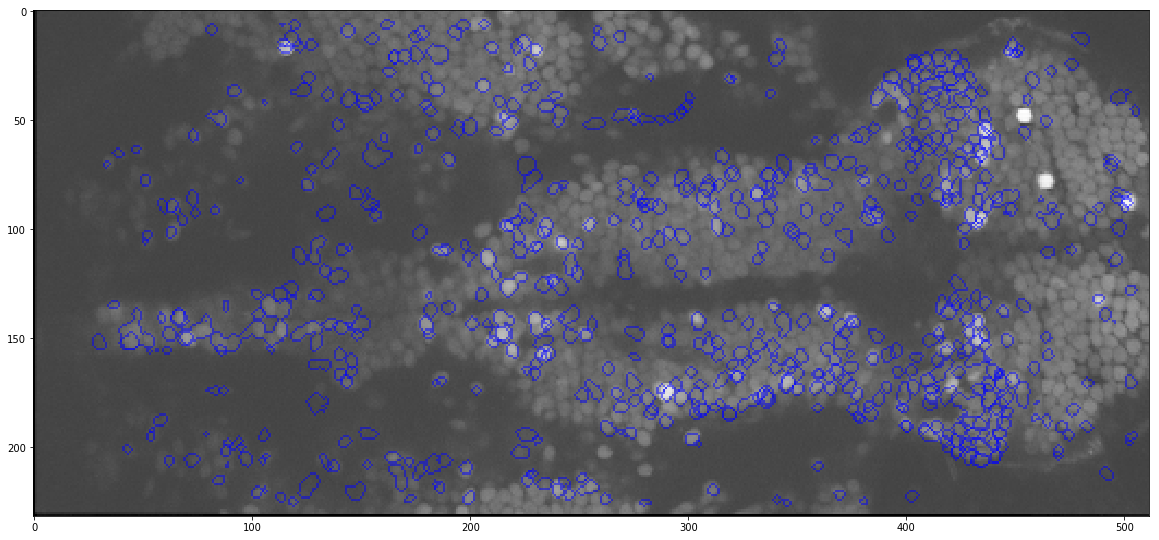

In [14]:
z=9
df, sig = f.get_cnmf_roi_table_and_signals()

#Create a background image by averaging 200 frames and adjusting the gamma.
back_img = np.power(f.get_tif_rasl_as_vol(z,range(1,200)).mean(axis=2),.4)

#Select rois in raphe in this slices, and get their coordinates.
poly_coords = df[(df.z==z)].poly
poly_coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]

#Overlay the ROIs on the background image and display:
img = vizutil.overlay_coords(back_img, poly_coords, [0,0,1], alpha=.5)
plt.figure(figsize=[20,20])
plt.imshow(img,interpolation='nearest')

In [15]:
df, sig = f.get_cnmf_roi_table_and_signals()
# bndx = (df.in_r_MHb) & (df.z==4)
# plt.plot(sig[bndx,:].mean(axis=0))

# Real data

In [16]:
def pearsonr(x, y):
    """
    Mimics `scipy.stats.pearsonr`

    Arguments
    ---------
    x : 1D torch.Tensor
    y : 1D torch.Tensor

    Returns
    -------
    r_val : float
        pearsonr correlation coefficient between x and y
    
    Scipy docs ref:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
    
    Scipy code ref:
        https://github.com/scipy/scipy/blob/v0.19.0/scipy/stats/stats.py#L2975-L3033
    Example:
        >>> x = np.random.randn(100)
        >>> y = np.random.randn(100)
        >>> sp_corr = scipy.stats.pearsonr(x, y)[0]
        >>> th_corr = pearsonr(torch.from_numpy(x), torch.from_numpy(y))
        >>> np.allclose(sp_corr, th_corr)
    """
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)
    xm = x.sub(mean_x)
    ym = y.sub(mean_y)
    r_num = xm.dot(ym)
    r_den = torch.norm(xm, 2) * torch.norm(ym, 2)
    r_val = r_num / r_den
    return r_val

def corrcoef(x):
    """
    Mimics `np.corrcoef`

    Arguments
    ---------
    x : 2D torch.Tensor
    
    Returns
    -------
    c : torch.Tensor
        if x.size() = (5, 100), then return val will be of size (5,5)

    Numpy docs ref:
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html
    Numpy code ref: 
        https://github.com/numpy/numpy/blob/v1.12.0/numpy/lib/function_base.py#L2933-L3013

    Example:
        >>> x = np.random.randn(5,120)
        # result is a (5,5) matrix of correlations between rows
        >>> np_corr = np.corrcoef(x)
        >>> th_corr = corrcoef(torch.from_numpy(x))
        >>> np.allclose(np_corr, th_corr.numpy())
        # [out]: True
    """
    # calculate covariance matrix of rows
    mean_x = torch.mean(x, 1, keepdim=True)
    xm = x.sub(mean_x.expand_as(x))
    c = xm.mm(xm.t())
    c = c / (x.size(1) - 1)

    # normalize covariance matrix
    d = torch.diag(c)
    stddev = torch.pow(d, 0.5)
    c = c.div(stddev.expand_as(c)+1e-8)
    c = c.div(stddev.expand_as(c).t()+1e-8)

    # clamp between -1 and 1
    # probably not necessary but numpy does it
    c = torch.clamp(c, -1.0, 1.0)

    return c

In [17]:
neuron_corr_cnmf = corrcoef(T.from_numpy(sig).cuda())

In [18]:
cnmf_linkage = hierarchy.linkage(
    distance.pdist(neuron_corr_cnmf), method='ward')

In [19]:
cnmf_linkage_clusters = hierarchy.fcluster(cnmf_linkage,4,criterion='maxclust')
# includes all neurons, even those without cluster
cluster_by_neuron = np.zeros(sig.shape[0]+1)
for i,v in enumerate(cnmf_linkage_clusters):
    cluster_by_neuron[i] = v
cluster_by_neuron = cluster_by_neuron[:-1]

multi
multi
multi
multi


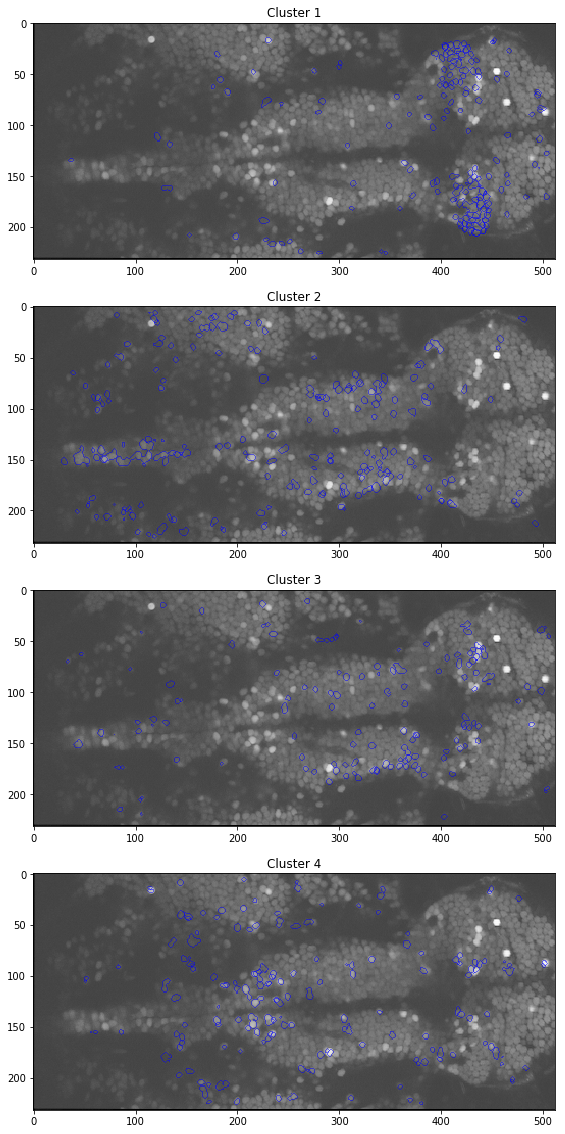

In [20]:
nclust = int(cluster_by_neuron.max())
plt.subplots(nclust,1, figsize=[10,5*nclust])
for clust in range(1,nclust+1):
    #Select rois in raphe in this slices, and get their coordinates.
    poly_coords = df[(cluster_by_neuron==clust) & (df.z==z)].poly
    poly_coords = [np.round(poly[~np.isnan(poly).any(axis=1)])[:,(1,0)].astype(int) for poly in poly_coords]
    plt.subplot(nclust,1,clust)
    #Overlay the ROIs on the background image and display:
    img = vizutil.overlay_coords(back_img, poly_coords, [0,0,1], alpha=.5)
    plt.imshow(img,interpolation='nearest')
    plt.title("Cluster {}".format(clust))

In [21]:
from pandas import DataFrame

In [22]:
def moving_average(a, n=3) :
    ret = np.cumsum(a,0)
    ret[n:] = ret[n:] - ret[:-n]
    rm = ret[n - 1:] / n
    pad_start = np.full((n-1,rm.shape[1]), rm[0])
    return np.vstack([pad_start, rm])

def ewma(data,span):
    df = DataFrame(data)
    return df.ewm(span).mean().values

def df_f(x,ma_window=6,span=6):
    u = moving_average(x,ma_window)
    return ewma((x - u)/u, span)

In [23]:
sig_t = T.from_numpy(sig.T.astype(np.float32)).cuda()
# M_T = T.from_numpy(M[bndx].T)

# dff_norm = (sig_t - dff.mean(0))/(dff.std(0)+1e-8)
# M_norm = (M_T - M_T.mean(0))/(M_T.std(0)+1e-8)

In [24]:
dtype = np.float32
x_fish = F.normalize(sig_t,0)
time_fish = T.from_numpy(f.frame_st.mean(1).astype(dtype)).cuda()
if dtype==np.float16:
    u_fish = T.cuda.HalfTensor(time_fish.shape).zero_()
    p_fish = T.cuda.HalfTensor(time_fish.shape).zero_()
else:
    u_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
    p_fish = T.cuda.FloatTensor(time_fish.shape).zero_()
u_fish[numpy.searchsorted(f.frame_et[:,-1], f.shock_st,side="left")] = 1


In [25]:
class DynamicsCluster(nn.Module,):
    def __init__(self, nfeatures, neuron_cluster_map, n_future_steps,dtype=T.float32, scale=1,std=0.1):
        """DCM model with dynamics between nclusters = max(neuron_cluster_map) features and dense mapping from
        nfeatures -> nclusters"""
        super(DynamicsCluster, self).__init__()
        if dtype==T.float32:
            tensor = T.cuda.FloatTensor
        elif dtype==T.float16:
            tensor = T.cuda.HalfTensor
        nclusters = int(max(neuron_cluster_map))
        self.nclusters = nclusters
        self.cluster = []
        for i in range(nclusters):
            idx = np.argwhere(neuron_cluster_map==i+1)[:,0]
            self.cluster.append(idx)
        self.Dense1 = nn.Parameter(tensor(nfeatures).normal_(std), requires_grad=True)
#         self.Dense2 = nn.Parameter(tensor(nfeatures).normal_(std), requires_grad=True)
        self.A = nn.Parameter(tensor(nclusters,nclusters).normal_(std),requires_grad=True)
        self.B = nn.Parameter(tensor(nclusters,nclusters).normal_(std),requires_grad=True)
        self.C = nn.Parameter(tensor(nclusters).normal_(std),requires_grad=True)
        self.n_future_steps = n_future_steps
        self.tensor = tensor
        self.scale = scale
        self.dtype = dtype

    def forward(self, u, p, x_true, n_future_steps=None):
        if n_future_steps==None:
            n_future_steps = self.n_future_steps
        # batch x time x feature
        x = self.tensor(x_true.shape[0], 1+x_true.shape[1], x_true.shape[2]).zero_()
        x[:,0] = x_true[:,0]
        for t in range(n_future_steps):
            X = T.cuda.FloatTensor(x_true.shape[0],self.nclusters, 1).zero_()
            for i in range(self.nclusters):
                idx = self.cluster[i]
                # broadcast inner product
                X[:,i] = T.matmul(x_true[:,t,None,idx],self.Dense1[idx])
            dxdt = (T.matmul((self.A + p[:,t,None,None]*self.B), X).squeeze()) + u[ :,t,None]*self.C
            for i in range(self.nclusters):
                idx = self.cluster[i]
                x[:,t+1,idx] = dxdt[:,i,None]/self.Dense1[idx] + x[:,t,idx]
        return x[:,1:]

In [26]:
n_future_steps = 1
batch_size = 64

data = FishSeqData(u_fish,p_fish,x_fish,n_future_steps)
model = DynamicsCluster(data.nfeatures,cluster_by_neuron,n_future_steps)

In [29]:
train(model,data,5,(1e-4,0),(1e-4,0),(1e-4,0),(1e-4,0), lr=1e-2,verbose=False)

  2%|▏         | 1/45 [00:00<00:07,  5.92it/s]

mse_loss: 7.606782E+01


  2%|▏         | 1/45 [00:00<00:07,  6.02it/s]

cum_loss: 2.522000E+04, mse_loss: 4.303713E+00


  2%|▏         | 1/45 [00:00<00:07,  6.06it/s]

cum_loss: 3.929836E+03, mse_loss: 6.673912E-01


  2%|▏         | 1/45 [00:00<00:07,  6.18it/s]

cum_loss: 2.815229E+03, mse_loss: 4.769807E-01


  2%|▏         | 1/45 [00:00<00:07,  6.04it/s]

cum_loss: 2.182847E+03, mse_loss: 3.689405E-01


100%|██████████| 45/45 [00:07<00:00,  6.06it/s]

cum_loss: 1.772357E+03, mse_loss: 2.988025E-01


100%|██████████| 89/89 [00:00<00:00, 283.88it/s]


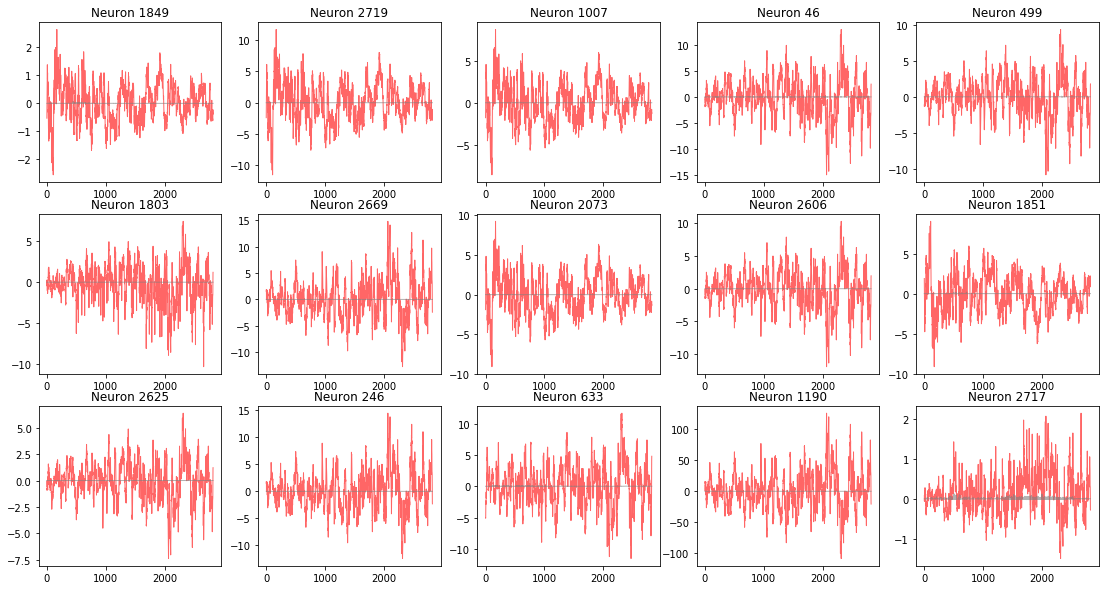

In [30]:
# data_train = FishSeqData(u_fish,p_fish,x_fish,1)
pred = predict(model, data).squeeze()
ncol, nrow = (5,3)
fig, ax = plt.subplots(nrow, ncol, figsize=(19,10))

# ax.set_ylabel("dx/dt")
# ax.set_xlabel("Time")
# ax.set_title("Training data")
dx_true = x_fish[1:] - x_fish[:-1]

for i in range(nrow):
    for j in range(ncol):
        n = np.random.randint(0,len(x_fish))
        ax[i,j].plot(pred[:,n].cpu().numpy(),color='red', alpha=0.6,linewidth=1, label="Model")
        ax[i,j].plot(dx_true[:,n].cpu().numpy(),color="gray", linewidth=1, alpha=0.6,label="Truth")
        ax[i,j].set_title("Neuron {}".format(n))
# fig

100%|██████████| 89/89 [00:00<00:00, 284.18it/s]


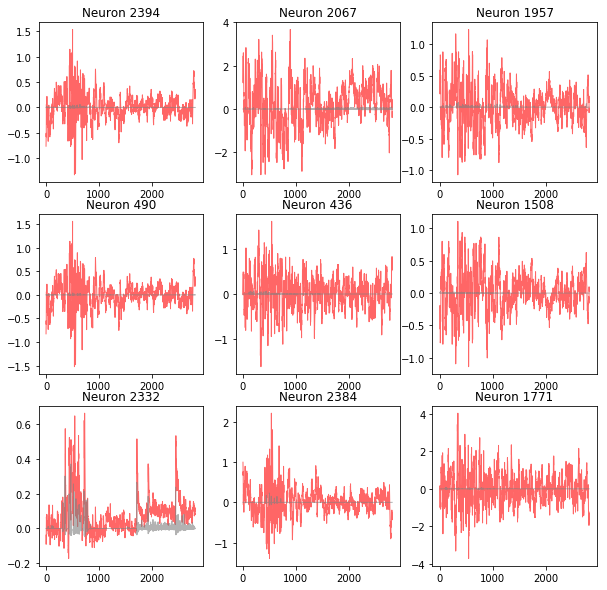

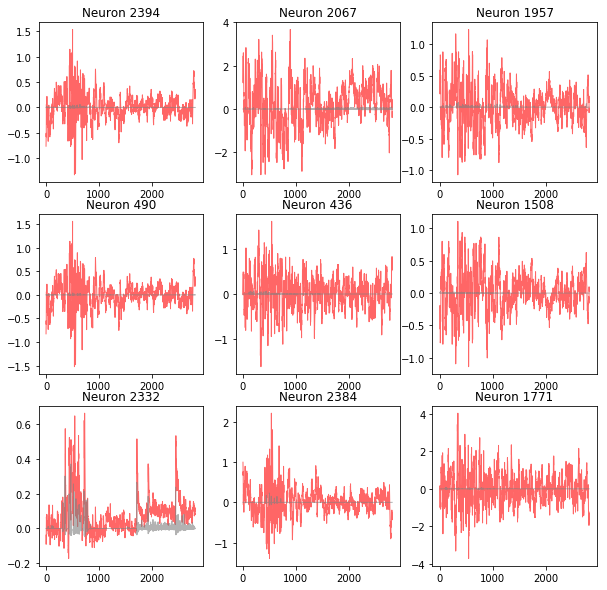

In [42]:
# data_train = FishSeqData(u_fish,p_fish,x_fish,1)
pred = predict(model, data).squeeze()

fig, ax = plt.subplots(3,3, figsize=(10,10))

# ax.set_ylabel("dx/dt")
# ax.set_xlabel("Time")
# ax.set_title("Training data")
dx_true = x_fish[1:] - x_fish[:-1]

for i in range(3):
    for j in range(3):
        n = np.random.randint(0,len(x_fish))
        ax[i,j].plot(pred[:,n].cpu().numpy(),color='red', alpha=0.6,linewidth=1, label="Model")
        ax[i,j].plot(dx_true[:,n].cpu().numpy(),color="gray", linewidth=1, alpha=0.6,label="Truth")
        ax[i,j].set_title("Neuron {}".format(n))

fig

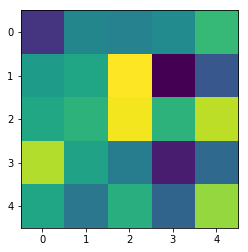

In [31]:
plt.imshow(model.A.cpu().detach().numpy())

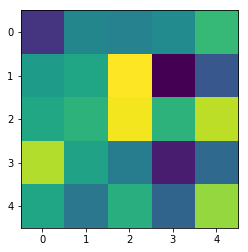

In [32]:
plt.imshow(model.A.cpu().detach().numpy())

In [32]:
ortho_regions = [u'in_r_cerebellum', u'in_l_cerebellum', u'in_l_vthal',
       u'in_l_tectum', u'in_l_raphe', u'in_r_hind', u'in_l_hind',
       u'in_l_dthal', u'in_r_tectum', u'in_r_LHb', u'in_r_dthal',
       u'in_r_raphe', u'in_r_tel',
       u'in_l_MHb', u'in_l_tel', u'in_r_MHb', u'in_l_LHb', u'in_r_vthal']

regions = df.columns[np.where([c in ortho_regions for c in df.columns])]
df = df.assign(region_id=pd.Series(np.full(len(df),-1).astype(np.int32)).values)
for i, region in enumerate(regions):
    idx = np.where(df[region])[0]
    df.loc[idx, "region_id"] = i
df[regions].sum(axis=0)


in_r_LHb      312
in_r_dthal    126
in_l_vthal    169
in_r_tel      116
in_l_raphe     21
in_r_raphe     25
in_l_tel       95
in_l_LHb      413
in_l_MHb      262
in_r_vthal    185
in_r_MHb      391
in_l_dthal    100
dtype: int64

In [33]:
neuron_map[[20,21,22]]

NameError: name 'neuron_map' is not defined

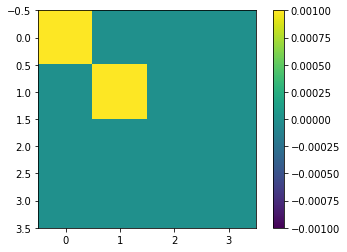

In [65]:
x = np.zeros([4,4])
x[[0,2],[0,2]] = 2
df_test = DataFrame({"region_id":[0,1,0,1]})
plot_matrix_by_region(x,df_test)

In [66]:
T.from_numpy(x.astype(np.float32)).norm(2)

tensor(2.8284)

In [53]:
def get_region(row,regions):
    return np.where(row[regions])[0][0]

def plot_matrix_by_region(W, df):
    neuron_map = np.argsort(df.where(df["region_id"]>=0)["region_id"]) # no region is -1
    nHasRegion = np.sum(neuron_map!=-1) + 1 # last -1 index will be removed
    newW = np.zeros(nHasRegion,nHasRegion)
    new_order = neuron_map[np.arange(W.shape[0])]
    new_order = new_order[new_order>=0]
    newW = W[new_order]
    newW = newW[:,new_order]
    plt.imshow(newW,vmin=-1e-3,vmax=1e-3)
    plt.colorbar()
    plt.show()

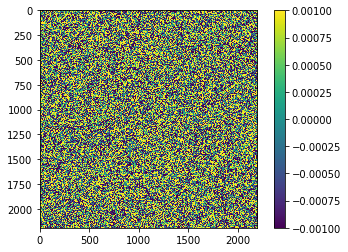

In [54]:
plot_matrix_by_region(model.A.cpu().detach().numpy(),df)

In [121]:
import seaborn as sb

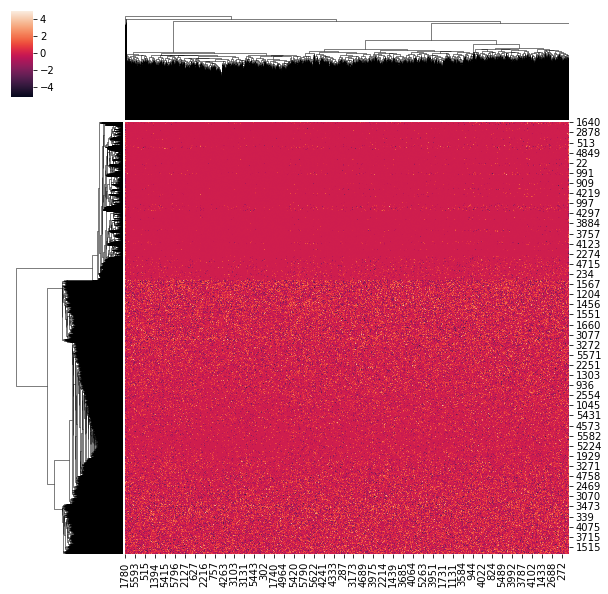

In [214]:
clustergrid = sb.clustermap(model.A.cpu().detach().numpy(), method='ward')

In [48]:
clustergrid

NameError: name 'clustergrid' is not defined

In [219]:
np.savez("cnmf_f01555",cnmf=sig.T, raw=M.T)

In [43]:
model.A.()

tensor(-3.9700, device='cuda:0')

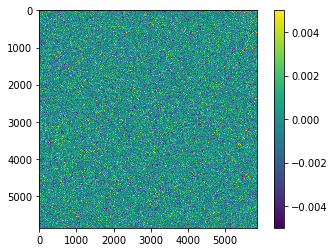

In [47]:
plt.imshow(model.A.cpu().detach().numpy(),vmin=-0.005,vmax=0.005)
plt.colorbar()
plt.show()

In [38]:
T.eq(model.A,T.cuda.FloatTensor(model.A.shape).zero_()).sum()

tensor(0, device='cuda:0')

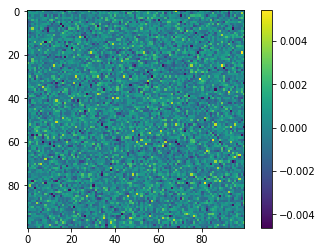

In [39]:
plt.imshow(model.B[:100,:100].cpu().detach().numpy())
plt.colorbar()
plt.show()

In [34]:
T.eq(model.B,T.cuda.FloatTensor(model.A.shape).zero_()).sum()

tensor(0, device='cuda:0')

# sort A by region

In [168]:
T.eq(model.A,T.cuda.FloatTensor(model.A.shape).zero_())[:].sum()

tensor(0, device='cuda:0')

In [156]:
x_fish[:,0].sum()

tensor(1.0805, device='cuda:0')

In [157]:
x_fish[0,:20]

tensor([-0.0696, -0.2842, -0.2871, -0.4898, -0.5523,  0.4254, -0.6074,
        -0.9745, -0.3179, -0.2270, -0.4128, -0.1738, -0.8195, -0.0783,
         2.0539, -0.2133, -0.2901, -0.7912, -0.5140, -0.5917], device='cuda:0')

In [158]:
model(u_fish[None,None,0],p_fish[None,None,0],x_fish[None,[0]],1).squeeze()

tensor([-1.7157e+02, -1.0985e+02,  1.0662e+02,  ...,  1.4352e+02,
        -3.8809e+00, -1.6126e+01], device='cuda:0')

In [159]:
x_fish[0]

tensor([-6.9612e-02, -2.8422e-01, -2.8705e-01,  ..., -3.8618e-01,
        -2.8714e-01, -1.6917e-02], device='cuda:0')

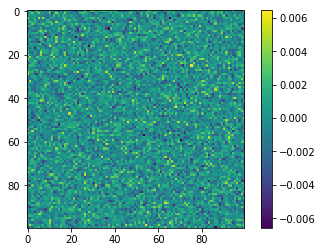

In [160]:
plt.imshow(model.B[:100,:100].cpu().detach().numpy())
plt.colorbar()
plt.show()

In [ ]:
stop

In [277]:
T.save(model.state_dict(),"fish_cnmf_decent")